# Team Assignment 3
# HE 381

## Team Members  
1. Abhijeet Bhatta (25169)
2. Ankush Kumar (24033)
3. Chanyanka Kakati (27228) 
4. Suman Dafadar (24139)


## Question 3

In [ ]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, SparsePauliOp
from qiskit.primitives import StatevectorEstimator, StatevectorSampler
from qiskit.circuit import Parameter, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFTGate
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

## Initial Hamiltonian Parameters

In [234]:
### Parameters #####
n_qubits = 3  # no of qubits per lattice site
phi_max    = 4.0 
lam      = 0.1 #Phi^4 term coeff
m        = 0.0
kappa    = 0.5 #couping term coeff
L        = 3   # no of lattice sites

## Exact diagnolization for getting benchmarks

In [235]:
### Exact diagnolization function for benchmarking and state initialzation 

import numpy as np
import scipy.linalg as la
from functools import reduce

def jlp_grids(n_qubits: int, phi_max: float):
    N  = 2**n_qubits
    dx = 2.0 * phi_max / (N - 1)
    j  = np.arange(N, dtype=float)
    x_vals = np.linspace(-phi_max, phi_max, N)
    k_vals = -np.pi/dx + (j + 0.5) * (2.0*np.pi)/(N * dx)
    return x_vals, k_vals, dx

def plane_wave_S(n_qubits: int, phi_max: float):
    x_vals, k_vals, _ = jlp_grids(n_qubits, phi_max)
    N = 2**n_qubits
    S = np.exp(1j * np.outer(k_vals, x_vals)) / np.sqrt(N)
    return S

def jlp_X_P(n_qubits: int, phi_max: float):
    x_vals, k_vals, _ = jlp_grids(n_qubits, phi_max)
    X = np.diag(x_vals.astype(complex))
    S = plane_wave_S(n_qubits, phi_max)
    P = S.conj().T @ np.diag(k_vals.astype(complex)) @ S
    return X, P

def single_site_H(n_qubits: int, phi_max: float, lam: float, m: float):
    X, P = jlp_X_P(n_qubits, phi_max)
    X2 = X @ X
    H_loc = 0.5*(P@P) + 0.5*(1.0)*X2 + lam*(X2@X2)
    return H_loc, X, P

# Kronecker helpers
def kronN(ops):
    """Kronecker product of list of operators"""
    return reduce(np.kron, ops)

def embed(op, site, L, d):
    """Embed single-site operator 'op' acting on site index 'site' (0-based)."""
    ops = [np.eye(d, dtype=complex)] * L
    ops = ops.copy()
    ops[site] = op
    return kronN(ops)

def embed_two(opA, siteA, opB, siteB, L, d):
    """Embed product of two-site operators (siteA<siteB)."""
    ops = [np.eye(d, dtype=complex)] * L
    ops = ops.copy()
    ops[siteA] = opA
    ops[siteB] = opB
    return kronN(ops)

def jlp_H_full(n_qubits: int, phi_max: float, lam: float, m: float,
               kappa: float, L: int):
    """Full lattice Hamiltonian with nearest-neighbor coupling."""
    d = 2**n_qubits
    H_loc, X, P = single_site_H(n_qubits, phi_max, lam, m)
    H_total = np.zeros((d**L, d**L), dtype=complex)

    # on-site terms
    for n in range(L):
        H_total += embed(H_loc, n, L, d)

    # coupling terms  -kappa X_n X_{n+1}
    for n in range(L-1):
        H_total += -kappa * embed_two(X, n, X, n+1, L, d)

    return H_total

def exact_diagonalize_full(n_qubits: int, phi_max: float,
                           lam: float, m: float, kappa: float, L: int):
    H_full = jlp_H_full(n_qubits, phi_max, lam, m, kappa, L)
    evals, evecs = la.eigh(H_full)
    return evals, evecs, H_full

# Jordan Lee Preskill encoding

Creating evolution operators for the diffrent terms in Hamiltonian

In [236]:
def x2_term(qc, m_ctr, delta_t, phi_max,site):
    qubits = len(site)
    x_prefactor = - phi_max / (2 ** qubits - 1)
    delta_x = 2 * phi_max / (2 ** qubits - 1)
    for i in range(qubits):
        for j in range(i + 1, qubits):
            qc.rzz(2 * 2 ** (i + j) * (1 + m_ctr) * x_prefactor ** 2 * delta_t, site[i], site[j])

In [237]:
def p2_term(qc, lam0f, delta_t, phi_max,site):
    qubits = len(site)
    delta_x = 2 * phi_max / (2 ** qubits - 1)
    p_prefactor = - np.pi / 2 ** qubits / delta_x
    alpha = (1 / 2 ** qubits - 1) * np.pi
    for i in range(qubits):
        qc.rz(alpha * 2 ** i, site[i])
    qc.append(QFTGate(qubits), site)
    for i in range(qubits):
        qc.rz(alpha * 2 ** i, site[i])
    for i in range(qubits):
        for j in range(i + 1, qubits):
            qc.rzz(2 * 2 ** (i + j) * lam0f * p_prefactor ** 2 * delta_t, site[i], site[j])
    for i in range(qubits):
        qc.rz(- alpha * 2 ** i, site[i])
    qc.append(QFTGate(qubits).inverse(), site)
    for i in range(qubits):
        qc.rz(- alpha * 2 ** i, site[i])

In [238]:
def rz4(qc, theta, i, j, k, l,site):
    qc.cx(site[i], site[j])
    qc.cx(site[j], site[k])
    qc.cx(site[k], site[l])
    qc.rz(theta, site[l])
    qc.cx(site[k], site[l])
    qc.cx(site[j], site[k])
    qc.cx(site[i], site[j]) 

In [239]:
def x4_term(qc, lam, delta_t, phi_max,site):
    qubits = len(site)
    x_prefactor = - phi_max / (2 ** qubits - 1)
    delta_x = 2 * phi_max / (2 ** qubits - 1)
    '''
    Apply the Z_i Z_j Z_k Z_l term: four site interaction
    '''
    for i in range(qubits):
        for j in range(i + 1, qubits):
            for k in range(j + 1, qubits):
                for l in range(k + 1, qubits):
                    coeff = 2 ** (i + j + k + l) * 24 * lam * x_prefactor ** 4
                    rz4(qc, 2 * coeff * delta_t, i, j, k, l,site)
    '''
    Apply the two-site piece with two and only two equal indices
    '''
    for i in range(qubits):
        for j in range(qubits):
            if j == i:
                continue
            for k in range(j + 1, qubits):
                if k == i:
                    continue
                coeff = 2 ** (2 * i + j + k) * 12 * lam * x_prefactor ** 4 # I wrote 2 * i  + j + l instead of k here in the video
                qc.rzz(2 * coeff * delta_t, site[j], site[k])
    '''
    Apply the two qubit interaction where three indices are equal
    '''
    for i in range(qubits):
        for j in range(qubits):
            if j == i:
                continue
            coeff = 2 ** (3 * i + j) * 4 * lam * x_prefactor ** 4
            qc.rzz(2 * coeff * delta_t, site[i], site[j])

In [240]:
def coupling_term(qc, delta_t, kappa, phi_max, n_qubits_site, site_n, site_np1):
    """
    Apply exp(+i kappa delta_t phi_n phi_{n+1})
    between two neighboring sites in JLP encoding.
    Each site has n_qubits_site qubits.
    site_n, site_np1 are lists of their qubit indices in the circuit.
    """
    prefactor = (phi_max / (2 ** n_qubits_site - 1)) ** 2
    for i in range(n_qubits_site):
        for j in range(n_qubits_site):
            theta = kappa * delta_t * prefactor * (2 ** (i + j))
            # Qiskit rzz(theta, i, j) = exp(-i theta/2 Z_i Z_j)
            qc.rzz(-2 * theta, site_n[i], site_np1[j])



## Strang expansion step

In [ ]:
def strang_step_lattice(qc, L, n_qubits_site, delta_t, lam, kappa, m_ctr, phi_max):
    # 1. Half-step of on-site block (A/2)
    for n in range(L):
        site = [n*n_qubits_site + i for i in range(n_qubits_site)]
        qc.barrier()
        x2_term(qc, m_ctr, delta_t/2, phi_max, site)   # add site index
        x4_term(qc, lam, delta_t/2, phi_max, site)
    # 2. Full-step of kinetic term (P^2) (A has π² part — still local)
    for n in range(L):
        site = [n*n_qubits_site + i for i in range(n_qubits_site)]
        p2_term(qc, 1, delta_t, phi_max, site)
    # 3. Full-step of coupling term (B)
    for n in range(L-1):
        site_n = [n*n_qubits_site + i for i in range(n_qubits_site)]
        site_np1 = [(n+1)*n_qubits_site + i for i in range(n_qubits_site)]
        coupling_term(qc, delta_t, kappa, phi_max, n_qubits_site, site_n, site_np1)
    # 4. Another full-step of kinetic (P^2)
    for n in range(L):
        site = [n*n_qubits_site + i for i in range(n_qubits_site)]
        p2_term(qc, 1, delta_t, phi_max, site)
    # 5. Second half-step of on-site block (A/2)
    for n in range(L):
        site = [n*n_qubits_site + i for i in range(n_qubits_site)]
        x2_term(qc, m_ctr, delta_t/2, phi_max, site)
        x4_term(qc, lam, delta_t/2, phi_max, site)


## Ramping Function
$$ r(u) = 3u^2 - 2 u^3 $$

In [242]:
# first thing is the ramp
def r(u):
    return u * u * (3.0 - 2.0 * u)

Ramping of lambda , kappa and their counter terms (depending on method chosen) 

In [243]:
def lamOf(u, lam):
    if 0.0 <= u <= 1.0:
        return lam * r(u)
    if 1.0 < u <= 2:
        return lam
    return 0

# \delta m^2 = - 6 \lambda^2
def dm2Of(u, lam):  ## mass counter term for lamda
    if 0.0 <= u <= 1.0:
        return - 6 * lam * r(u)
    if 1.0 < u <= 2:
        return - 6 * lam * (1 - r(u - 1))
    return 0.0

def dm2Of_kappa(u, kappa0): 
    """
    Counterterm for kappa-ramp.
    Keeps the physical curvature fixed while turning on/off inter-site coupling.
    """
    if 0.0 <= u <= 1.0:
        # ramp up κ: δm² = -2 κ(u)
        return -2 * kappa0 * r(u)
    if 1.0 < u <= 2:
        # ramp down counterterm: δm² goes back to 0
        return -2 * kappa0 * (1 - r(u - 1))
    return 0.0

def kapOf(u, kappa): ## mass counter term for kappa
    if 0.0 <= u <= 1.0:
        return kappa * r(u)
    if 1.0 < u <= 2:
        return kappa
    return 0


Need to build the full adiabatic evolution circuit

In [244]:
def build_circuit_gs_prep(num_qubits,gs):
    qc = QuantumCircuit(num_qubits)
    qc.initialize(gs)
    return qc

In [245]:
def build_circuit(qc,lam,kappa, num_qubits, phi_max, method,tPrep = 25.0, nSteps = 250):
    '''
    Part A:
    First we need to build the x^2 + p^2 ground state.
    '''
    # qc = build_circuit_gs_prep(num_qubits)
    '''
    Part B:
    Now go to lambda * x^4 ground state with adiabatic state prep
    '''
    dt = tPrep / 2 / nSteps
    if method == 1:
        for j in range(1, 2 * nSteps + 1):
            u = (j - 0.5) / nSteps
            lam_t = lamOf(u, lam)
            dm_ctr = dm2Of(u, lam)
            strang_step_lattice(qc,L,n_qubits,dt ,lam_t,kappa, dm_ctr, phi_max)
        return qc
    elif method == 2:
        for j in range(1, 2 * nSteps + 1):
            u = (j - 0.5) / nSteps
            kap_t = kapOf(u, kappa)
            dm_ctr = dm2Of_kappa(u, kappa)
            strang_step_lattice(qc,L,n_qubits,dt ,lam ,kap_t, dm_ctr, phi_max)
        return qc  

In [246]:
# ### Parameters #####
# n_qubits = 3  # no of qubits per lattice site
# phi_max    = 4.0 
# lam      = 0.1 #Phi^4 term coeff
# m        = 0
# kappa    = 1 #couping term coeff
# L        = 3   # no of lattice sites

# Method 1 (Adiabatic state preperation by ramping Lamda term) 


Initialize ground state $|\psi\rangle_{init}$ for $\lambda =0$ and $\kappa =\kappa$

In [247]:
evals, evecs, H = exact_diagonalize_full(n_qubits, phi_max, 0, m, kappa, L)
gs_lamda0 = evecs[:, 0] 
qc_init = build_circuit_gs_prep(L*n_qubits, gs_lamda0)

In [248]:
qc = build_circuit(qc_init,lam,kappa, L*n_qubits, phi_max,1)

In [249]:
state_1 = Statevector.from_instruction(qc)

## Check against Benchmark

In [250]:

evals, evecs, H = exact_diagonalize_full(n_qubits, phi_max, lam, m, kappa, L)
v0 = evecs[:, 0]
print("Ground energy:", evals[0].real)

overlap = float(abs(np.vdot(v0, state_1))**2)
print("Fidelity of ASP with method 1 vs diagnolized Ground state", overlap)

Ground energy: 1.628486186610842
Fidelity of ASP with method 1 vs diagnolized Ground state 0.9596966906620674


# Method 2 (Adiabatic state preperation by ramping kappa term) 

Initialize ground state $|\psi\rangle_{init}$ for $\lambda =\lambda$ and $\kappa =0$

In [251]:
evals, evecs, H = exact_diagonalize_full(n_qubits, phi_max, lam, m, 0, L)
gs_kappa0 = evecs[:, 0] 
qc_init = build_circuit_gs_prep(L*n_qubits, gs_kappa0)

In [252]:
qc = build_circuit(qc_init,lam,kappa, L*n_qubits, phi_max,2)
state_2 = Statevector.from_instruction(qc)

## Check against Benchmark

In [253]:
evals, evecs, H = exact_diagonalize_full(n_qubits, phi_max, lam, m, kappa, L)
v0 = evecs[:, 0]
print("Ground energy:", evals[0].real)

overlap = float(abs(np.vdot(v0, state_2))**2)
print("Fidelity of ASP with method 2 vs diagnolized Ground state", overlap)

Ground energy: 1.628486186610842
Fidelity of ASP with method 2 vs diagnolized Ground state 0.901332125624279


# Result 
we see that the fidelity of true ground state to the ground state for ASP by ramping $\kappa$ is lower than that of ASP by ramping $\lambda$ for the same time interval and time steps 

# Comparision of Fidelities

L=3, n_qubits=2, d_site=4, total dim=64
Target ground energy = 9.824286775062467
Init (g-ramp) ground energy = 5.081114046308162
Init (k-ramp) ground energy = 7.689628153481036
Fidelity (lambda-ramp) = 0.999999
Fidelity (kappa-ramp)  = 0.806843


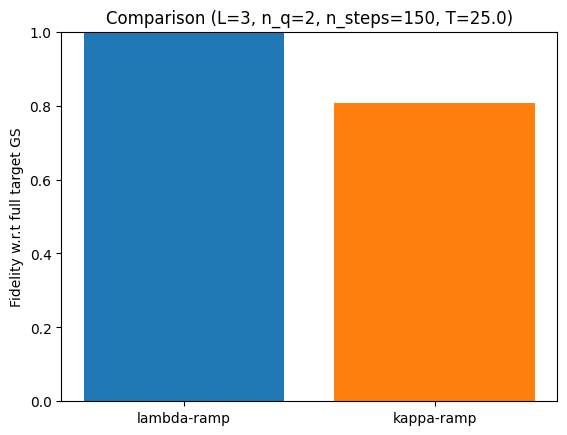

In [256]:

# Save parameters and show setup
L = 3    # number of lattice sites (small for exact diagonalization)
n_qubits = 2    # qubits per site (Hilbert dim per site d=2**n_qubits)
x_max = 4.0        # JLP field truncation range
lam0 = 0.5         # target lambda (quartic coupling)
kappa0 = 1      # target kappa (nearest-neighbour coupling)
m_code = 1.0       # on-site mass-squared coefficient in code convention (bare mass)
T = 25.0           # total evolution time for each method
n_steps = 150      # number of constant time steps (same for both methods)
print(f"L={L}, n_qubits={n_qubits}, d_site={2**n_qubits}, total dim={(2**n_qubits)**L}")



import numpy as np
import scipy.linalg as la
from functools import reduce


def jlp_grids(n_qubits: int, x_max: float):
    N  = 2**n_qubits
    dx = 2.0 * x_max / (N - 1)
    j  = np.arange(N, dtype=float)
    x_vals = np.linspace(-x_max, x_max, N)
    k_vals = -np.pi/dx + (j + 0.5) * (2.0*np.pi)/(N * dx)
    return x_vals, k_vals, dx

def plane_wave_S(n_qubits: int, x_max: float):
    x_vals, k_vals, _ = jlp_grids(n_qubits, x_max)
    N = 2**n_qubits
    S = np.exp(1j * np.outer(k_vals, x_vals)) / np.sqrt(N)
    return S

def jlp_X_P(n_qubits: int, x_max: float):
    x_vals, k_vals, _ = jlp_grids(n_qubits, x_max)
    X = np.diag(x_vals.astype(complex))
    S = plane_wave_S(n_qubits, x_max)
    P = S.conj().T @ np.diag(k_vals.astype(complex)) @ S
    return X, P


def single_site_H_components(n_qubits: int, x_max: float, lam: float, m_on_site: float):
    X, P = jlp_X_P(n_qubits, x_max)
    X2 = X @ X
    H_loc = 0.5*(P@P) + 0.5*(m_on_site)*X2 + lam*(X2@X2)
    return H_loc, X, P, X2


# Kronecker helpers
def kronN(ops):
    return reduce(np.kron, ops)

def embed(op, site, L, d):
    ops = [np.eye(d, dtype=complex)] * L
    ops[site] = op
    return kronN(ops)

def embed_two(opA, siteA, opB, siteB, L, d):
    ops = [np.eye(d, dtype=complex)] * L
    ops[siteA] = opA
    ops[siteB] = opB
    return kronN(ops)


def build_full_H(n_qubits, x_max, lam, m_code, kappa, L, delta_m2=0.0):
    # note: on-site coefficient should be m_code + 2*kappa + delta_m2
    d = 2**n_qubits
    H_loc, X, P, X2 = single_site_H_components(n_qubits, x_max, lam, m_code + 2.0*kappa + delta_m2)
    H_total = np.zeros((d**L, d**L), dtype=complex)
    # on-site
    for n in range(L):
        H_total += embed(H_loc, n, L, d)
    # coupling
    for n in range(L-1):
        H_total += -kappa * embed_two(X, n, X, n+1, L, d)
    return H_total, X


# small helper: instantaneous counterterms (perturbative)
def r(u):
    return u*u*(3 - 2*u)

def dm2_g(u, lam_target, omega0):
    # perturbative one-loop estimate for single-site like earlier: -6*g / omega0
    return -6.0 * lam_target * r(u) / omega0

def dm2_g_ramp_value(u, lam_target, omega0):
    # full schedule for u in [0,2] (ramp up then hold) - but here we will use up->hold->down cycles per scheme
    if 0.0 <= u <= 1.0:
        return -6.0 * lam_target * r(u) / omega0
    elif 1.0 < u <= 2.0:
        return -6.0 * lam_target * (1 - r(u - 1.0)) / omega0
    else:
        return 0.0

def dm2_kappa(u, kappa_target):
    # lattice-level simple counterterm -2*kappa during ramp-up, and ramp down back to 0
    if 0.0 <= u <= 1.0:
        return -2.0 * kappa_target * r(u)
    elif 1.0 < u <= 2.0:
        return -2.0 * kappa_target * (1.0 - r(u - 1.0))
    else:
        return 0.0


# Build target full Hamiltonian (final physical Hamiltonian) to compute true ground state
H_target, X_single = build_full_H(n_qubits, x_max, lam0, m_code, kappa0, L, delta_m2=0.0)
evals_target, evecs_target = la.eigh(H_target)
gs_target = evecs_target[:,0]
print('Target ground energy =', evals_target[0].real)


# Prepare initial ground states for the two methods (exact diagonalization on initial Hamiltonians)
# Method 1 initial Hamiltonian: lambda=0, kappa = kappa0 (we assume site AHOs with kappa present)
H_init_g, _ = build_full_H(n_qubits, x_max, 0.0, m_code, kappa0, L, delta_m2=0.0)
evals_g, evecs_g = la.eigh(H_init_g)
gs_init_g = evecs_g[:,0]

# Method 2 initial Hamiltonian: lambda = lam0, kappa = 0
# For k-ramp we start with decoupled AHOs at lambda = lam0 (each site's interacting ground state)
# that's equivalent to the product of single-site interacting GS; but we can get full many-body GS of kappa=0
H_init_k, _ = build_full_H(n_qubits, x_max, lam0, m_code, 0.0, L, delta_m2=0.0)
evals_k, evecs_k = la.eigh(H_init_k)
gs_init_k = evecs_k[:,0]

print('Init (g-ramp) ground energy =', evals_g[0].real)
print('Init (k-ramp) ground energy =', evals_k[0].real)


# Time evolution helper: evolve state under time-dependent Hamiltonian with constant steps
def time_evolve_state(initial_state, H_list, dt):
    psi = initial_state.copy()
    for H in H_list:
        U = la.expm(-1j * H * dt)
        psi = U @ psi
    # normalize numeric
    psi = psi / np.linalg.norm(psi)
    return psi


# Build H schedules for both methods using same n_steps and total time T
dt = T / n_steps

def build_H_schedule_method1(n_steps):
    # Method1: ramp lambda from 0->lam0 over u in [0,1], then hold lam=lam0 and dm2 ramp down in [1,2]
    H_list = []
    # precompute omega0 from single-site initial (kappa present)
    # approximate omega0 using on-site coefficient m_code + 2*kappa0
    omega0 = np.sqrt(max(1e-8, m_code + 2.0*kappa0))
    for j in range(1, n_steps+1):
        u = (j-0.5) / n_steps  # map to 0..1 for ramp (we only do a single-stage ramp here)
        lam_u = lam0 * r(u)
        dm2 = dm2_g(u, lam0, omega0)
        H_u, _ = build_full_H(n_qubits, x_max, lam_u, m_code, kappa0, L, delta_m2=dm2)
        H_list.append(H_u)
    return H_list

def build_H_schedule_method2(n_steps):
    # Method2: ramp kappa from 0->kappa0 over u in [0,1], then hold kappa=kappa0 and dm2 ramp down later
    H_list = []
    # initial omega estimate based on m_code (kappa=0)
    for j in range(1, n_steps+1):
        u = (j-0.5) / n_steps
        k_u = kappa0 * r(u)
        dm2 = dm2_kappa(u, kappa0)
        H_u, _ = build_full_H(n_qubits, x_max, lam0, m_code, k_u, L, delta_m2=dm2)
        H_list.append(H_u)
    return H_list


# Build schedules and evolve both initial states under their respective Hamiltonian lists
H_sched_g = build_H_schedule_method1(n_steps)
H_sched_k = build_H_schedule_method2(n_steps)

psi_final_g = time_evolve_state(gs_init_g, H_sched_g, dt)
psi_final_k = time_evolve_state(gs_init_k, H_sched_k, dt)

# Compute fidelities with true target GS
fid_g = np.abs(np.vdot(gs_target.conj(), psi_final_g))**2
fid_k = np.abs(np.vdot(gs_target.conj(), psi_final_k))**2
print(f'Fidelity (lambda-ramp) = {fid_g:.6f}')
print(f'Fidelity (kappa-ramp)  = {fid_k:.6f}')


# Also provide numpy checks: overlap of instantaneous GS at final time vs evolved state (sanity)
# Instantaneous ground state of final Hamiltonians (should be same as target)
evals_fin_g, evecs_fin_g = la.eigh(H_sched_g[-1])
evals_fin_k, evecs_fin_k = la.eigh(H_sched_k[-1])
gs_fin_g = evecs_fin_g[:,0]
gs_fin_k = evecs_fin_k[:,0]

# ov_g = np.abs(np.vdot(gs_fin_g.conj(), psi_final_g))**2
# ov_k = np.abs(np.vdot(gs_fin_k.conj(), psi_final_k))**2
# print(f'Overlap evolved vs instantaneous final GS (method1) = {ov_g:.6f}')
# print(f'Overlap evolved vs instantaneous final GS (method2) = {ov_k:.6f}')


# Quick plot of fidelities vs method (bar)
import matplotlib.pyplot as plt
plt.bar(['lambda-ramp','kappa-ramp'], [fid_g, fid_k], color=['C0','C1'])
plt.ylim(0,1)
plt.ylabel('Fidelity w.r.t full target GS')
plt.title(f'Comparison (L={L}, n_q={n_qubits}, n_steps={n_steps}, T={T})')
plt.show()

#     evals, evecs, H = exact_diagonalize_full(n_qubits, phi_max, 0, m, kappa, L)
#     gs_lamda0 = evecs[:, 0] 
#     qc_init = build_circuit_gs_prep(L*n_qubits, gs_lamda0)
#     qc = build_circuit(qc_init,lam,kappa, L*n_qubits, phi_max,1)
#     state_1 = Statevector.from_instruction(qc)
#     method_1_fid.append(float(abs(np.vdot(v0, state_1))**2))
#     print("Fidelity of ASP with method 2 vs diagnolized Ground state", overlap)